In [1]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import re
import scipy as sp
import json
import requests
import warnings
sns.set_context('notebook')
warnings.filterwarnings('ignore')

In [2]:
merge_raw=pd.read_pickle('merge_raw.pkl')
merge_geo=merge_raw.copy()
#merge_geo=merge_geo.groupby('title','production_countries').mean()
merge_geo.head(1)

,title,cast,budget,genres,keywords,original_language,popularity,production_companies,production_countries,revenue,...,related,asin,reviewText,reviewerName,helpful,summary,overall,reviewerID,unixReviewTime,reviewTime
0,The Chronicles of Narnia: Prince Caspian,"[Ben Barnes, William Moseley, Anna Popplewell,...",225000000,"[Adventure, Family, Fantasy]","[based on novel, fictional place, brother sist...",en,53.978602,"[Walt Disney, Walden Media, Stillking Films, O...","[Czech Republic, Poland, Slovenia, United Stat...",419651413,...,"{'also_bought': ['B004M1A21K', 'B000E8M0VA', '...",B00005JPH2,Highly recommended for parents and children. ...,"1gewehr ""1gewehr""","[0, 0]",Lots of action and adventure,4.0,A2FI56P3ZSOUWG,1377043200,"08 21, 2013"


We try to analyze the rating and related feature from the point of geographic distribution. We can get the sum of rating and the number of movies each country in the dataset has participated in, and get the dataframe.

In [4]:
country_count = pd.Series(get_count(merge_raw['production_countries']))
ratings_array=[]
sf_array=[]
for temp_country in country_count.index:
    temp_count=0
    temp_sf_count=0
    temp_rating_sum=0
    sf_rating_sum=0
    for i in range(len(merge_geo)):
        if temp_country in merge_geo['production_countries'].values[i]:
            temp_rating_sum=temp_rating_sum+merge_geo.overall.values[i]
            temp_count=temp_count+1
            if 'Comedy' in merge_geo.genres.values[i]:
                sf_rating_sum=sf_rating_sum+merge_geo.overall.values[i]
                temp_sf_count=temp_sf_count+1
    temp_country_rating=temp_rating_sum/temp_count
    if temp_sf_count==0:
        sf_country_rating=0
    else:
        sf_country_rating=sf_rating_sum/temp_sf_count
    ratings_array=ratings_array+[temp_country_rating]
    sf_array=sf_array+[sf_country_rating]
country_ratings = pd.DataFrame({'Country':np.array(country_count.index),'overall_rating':np.array(ratings_array),
                                'comedy_rating':np.array(sf_array)})
country_ratings.tail()

,Country,comedy_rating,overall_rating
0,Afghanistan,0.0,4.528571
1,Argentina,0.0,3.427350
2,Aruba,0.0,3.321429


Since there is only country name in the dataset without accurate Latitude or Longitude, we find a file online that could correspond the country name to its centroid coordinations. We read the csv file and use country name to merge it with our previous dataframe.

In [24]:
geo_info=pd.read_csv('data/geolocations.csv')
loc_ratings=pd.merge(country_ratings,geo_info,on='Country')
loc_ratings.head(1)

,Country,comedy_rating,overall_rating,ISO 3166 Country Code,Latitude,Longitude
0,Afghanistan,0.0,4.528571,AF,33.0,65.0


In [25]:
heat_data=[]
for i in range(len(loc_ratings)):
    temp_lat=loc_ratings.Latitude.values[i]
    temp_lon=loc_ratings.Longitude.values[i]
    temp_ratings=loc_ratings.overall_rating.values[i]
    temp_heat_data=[temp_lat,temp_lon,temp_ratings]
    heat_data=heat_data+[temp_heat_data]

We use folium to visualize the geoprahic distribution in maps.Heatmap is used to centralized distribution of movie-produced counntries in global map, with corresponding rating values.

In [31]:
import folium
from folium.plugins import HeatMap
m = folium.Map([ 0, 0], tiles='stamentoner', zoom_start=2)
HeatMap(heat_data).add_to(m)
m.save('images/Overall_Distribution_with_Heatmap.html')
display(m)

From the heatmap, we can oberve the movies in the dataset have a concentrated distribution in east and middle Europe, America and east Asia

And we now focus on the rating ditribution, we use a circle to represent for the average rating of a country, the larger the radiums of the circle, the higher average rating a country gets.

In [32]:
m1 = folium.Map(location=[0,0], zoom_start=2)
for i in range(len(loc_ratings)):
    folium.Circle(
      location=[loc_ratings.iloc[i]['Latitude'], loc_ratings.iloc[i]['Longitude']],
      popup=loc_ratings.iloc[i]['ISO 3166 Country Code'],
      radius=loc_ratings.iloc[i]['overall_rating']*80000,
      color='blue',
      fill=True,
      fill_color='blue'
      ).add_to(m1)
m1.save('images/Overall_Ratings_with_Circles.html')
display(m1)

Larger circles exist in north Eruope and noth America, which means the ratings are visually higher in these areas than the other part of the world.

To make the rating distribution clearer, we use the choropleth in folium, thus using color in the country borders to represent for the average rating of the country. Also we get a file that relates each potential country name with corresponding detailed border coordinates.

To give the white color to the countries that do not participate any film in our merged dataset, otherwise it will be represented by the deepest color. We fill the area in each country border with the color related to its average rating value.

In [36]:
nan_handle_function = lambda data: {'fillColor':'#ffffff',
                                    'fillOpacity': '1' if (data['features']['properties']['name'] in loc_ratings.Country.values )==False
                                    else '0'}

In [37]:
geo_border = json.load(open('countries_borders.geo.json'))
m.choropleth(geo_data=geo_border, data=country_ratings,
             columns=['Country', 'overall_rating'],
             key_on='feature.properties.name',
             fill_color='YlGn', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Geographic Distribution of Overall Movie Ratings')

In [38]:
folium.TopoJson(
    geo_border,
    'feature.properties.name',
    style_function=nan_handle_function,
    control=False
).add_to(m)

m.save('images/Overall_Ratings_with_Heatmap.html')
display(m)

The average of ratings for all movies in each country is shown above, most areas have an average rating of about 3.5, and the average is especially higher in Europe, east Asia, north Africa, North America and India through the global map.

Now by focusing on the average rating of comedy movies and get the map again to visualize the geographic distribution of comedy movies.

In [46]:
md = folium.Map([ 0, 0], tiles='stamentoner', zoom_start=2)
heat_data=[]
for i in range(len(loc_ratings)):
    temp_lat=loc_ratings.Latitude.values[i]
    temp_lon=loc_ratings.Longitude.values[i]
    temp_ratings=loc_ratings.comedy_rating.values[i]
    temp_heat_data=[temp_lat,temp_lon,temp_ratings]
    heat_data=heat_data+[temp_heat_data]
HeatMap(heat_data).add_to(md)
md.choropleth(geo_data=geo_border, data=country_ratings,
             columns=['Country', 'comedy_rating'],
             key_on='feature.properties.name',
             fill_color='YlGn', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Geographic Distribution of Comedy Ratings')
folium.TopoJson(
    geo_border,
    'feature.properties.name',
    style_function=nan_handle_function,
    control=False
).add_to(md)
md.save('images/Comedy_Ratings_with_Heatmap.html')
display(md)

Most countries have the similar average rating with all movies, and it can be understood that most countries develop each genre of movies with same efforts. However,colors become obviously lighter in China, Russia and South America, there areas are not good at making people laugh compared with other countries.

Maps are also used to visualize the relationship between vote and rating among countries. First, we get the average rate of all the movies in each potential country in the dataset.

In [24]:
va_array=[]
for temp_country in country_count.index:
    temp_count=0
    va_sum=0
    for i in range(len(merge_geo)):
        if temp_country in merge_geo['production_countries'].values[i]:
            va_sum=va_sum+merge_geo.vote_average.values[i]
            temp_count=temp_count+1
    temp_country_va=va_sum/temp_count
    va_array=va_array+[temp_country_va]

We introduce a proportion temp_pop to represent a linear relationship between average vote and average rating since the maxium values of vote and rating are not identical. We use the proportion to make both values share the same range.

In [39]:
country_va=pd.DataFrame({'Country':np.array(country_count.index), 'vote_average':np.array(va_array)})
country_rating_va=pd.merge(country_ratings,country_va,on='Country')
temp_prop=max(merge_geo['vote_average'])/max(merge_geo['overall'])
country_rating_va['V/R']=(country_rating_va['vote_average']-country_rating_va['overall_rating']*temp_prop)/(country_rating_va['overall_rating']*temp_prop)
country_rating_va.tail(2)

,Country,comedy_rating,overall_rating,vote_average,V/R
43,United Kingdom,4.074607,4.018485,6.655361,-0.025773
44,United States of America,3.918996,3.939228,6.458872,-0.035512


Instead of visualizing the value of pure vote, we use change trend of vote against rating by division, which can show the interconnenction between 2 values and use the folium to plot a map. We use the value of (vote-rating)/rating to represent for the distribution.

In [68]:
geo_border = json.load(open('countries_borders.geo.json'))
m_vr = folium.Map([ 0, 0], zoom_start=2)
m_vr.choropleth(geo_data=geo_border, data=country_rating_va,
             columns=['Country', 'V/R'],
             key_on='feature.properties.name',
             fill_color='BuPu', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Vote Average vs Rating')
folium.TopoJson(
    geo_border,
    'feature.properties.name',
    style_function=nan_handle_function,
    control=False
).add_to(m_vr)
m_vr.save('images/Vote_Average_vs_Rating.html')
display(m_vr)

Except in some areas in Africa, most countries have the 2 lightest colors among the threshold, and the value is around 0.Therefore, the value of vote does have a strong relationship with Amazon ratings, and can been seen as a linear relationship, although it's not strictly linear by some bias from the accurate 0.

Now we use another intuitive graph to visualize the relationship, focusing on the average rating and average vote of 20 countries that produce most movies.

In [58]:
country_line=country_rating_va[['Country','overall_rating','vote_average']].sort_values(by='overall_rating',ascending=False)
country_line=country_line.iloc[:20]
country_line['vote_average']=country_line['vote_average']/temp_prop
country_line = country_line.groupby('Country').mean()

In [59]:
country_line = country_line.loc[:,["overall_rating","vote_average"]]
country_line = country_line.stack()
country_line = country_line.to_frame()
country_line.reset_index(inplace=True)
country_line.columns = country_line.columns.astype(str)
country_line.rename(columns={"level_1":"type","0":"value"},inplace=True)

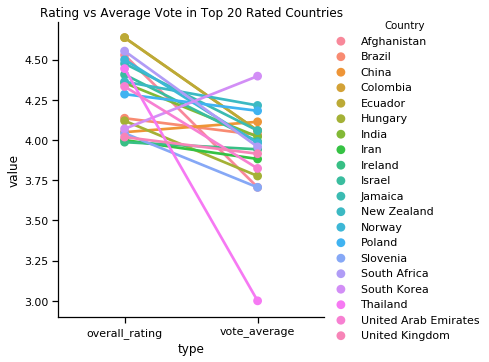

In [60]:
sns.catplot(x="type", y="value",hue="Country", kind="point", data=country_line)
plt.title("Rating vs Average Vote in Top 20 Rated Countries")
plt.show()

Most lines in the graph are parallell to each other, proving to having a not strictly linear relationship. Nearly all countries have a lower value in average vote after dividing it by the proportion. It turns out compard to Amazon rating, TMDB vote is a bit more strict. The phenomena conform to our representation in the vote geographic distribution above.

Now we turn to the analysis of reviews, which is mainly determined by text processing.
Firstly, we use wordcloud to take a glance at the keyword in the review text.

We import the library wordcloud.

In [57]:
from wordcloud import *
import matplotlib.pyplot as plt
import imageio

We define a function to get the word in the review of the type we desire to analyze.

In [58]:
merge_key=merge_raw.copy()
def get_review(genre,temp_genre):
    review_sum=''
    for i in range(len(merge_key)):
        if temp_genre in str(merge_key[genre].values[i]):
            temp_review=merge_key.reviewText.values[i]
            review_sum=review_sum + temp_review+' '
    return review_sum

Not all the words in the review are useful, so another function is defined to delete the useless words and store other words into wordcloud. Fianlly, the function helps to plot a figure with required background mask by the useful keywords it stores.

In [59]:
def show_word(temp_review,mask_name,temp_title):
    del_word = ['movie','film','look','see','seen','must','said','feel','want','make','something','audience','get','either','never','though',
            'yet','guy','one','time','even','will','really','made','now','us','DVD','say','know','come']
    stopword = STOPWORDS|set(del_word)
    temp_mask=imageio.imread('mask/'+mask_name+'_mask.jpg')
    temp_wc = WordCloud(background_color='white',mask=temp_mask,colormap="Set2_r",
                      stopwords=stopword,max_words=2000,max_font_size=200,random_state=30).generate(temp_review)
    temp_fig=plt.figure(figsize=(12, 8))
    plt.imshow(temp_wc)
    plt.title(temp_title) 
    plt.axis('off')
    plt.show()

We get the review keywords of science fiction and animation movies from defined function. Also, we get the keywords of movies rated 1.0 and 5.0.

In [60]:
sf_review=get_review('genres','Science Fiction')
anm_review=get_review('genres','Animation')
rating_5_review=get_review('overall','5.0')
rating_1_review=get_review('overall','1.0')

We can visualize the keywords of science fiction movies and animation movies with the masks of Transformers and Pikachu.

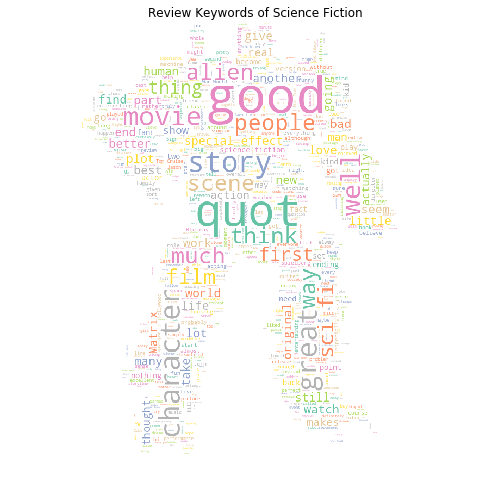

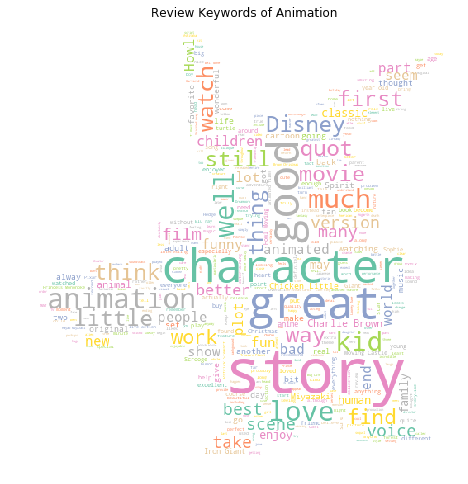

In [61]:
show_word(sf_review,'science_fiction','Review Keywords of Science Fiction')
show_word(anm_review,'animation', 'Review Keywords of Animation')

Also, review keywords of movies rated 1 and 5 can be visualized with the mask of thumb up and thumb down.

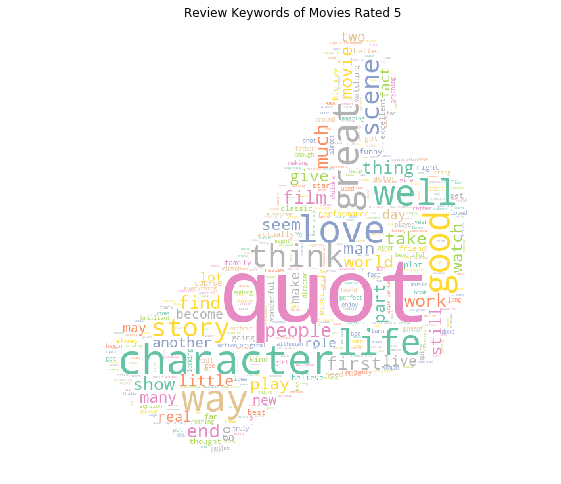

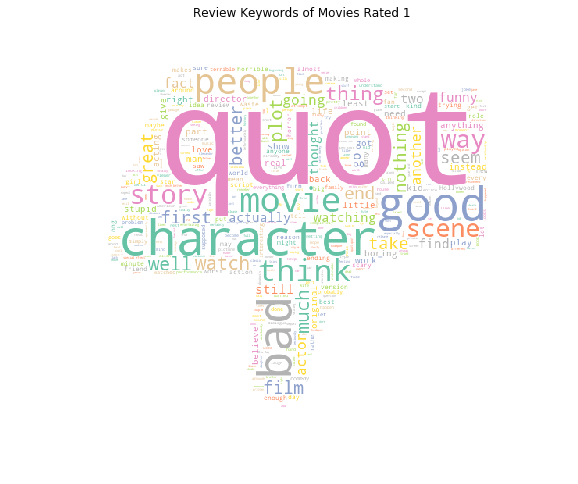

In [62]:
show_word(rating_5_review,'5','Review Keywords of Movies Rated 5')
show_word(rating_1_review,'1','Review Keywords of Movies Rated 1')

Well, from the visualization of review keywords, there are differnt specific words in specific genres (alien in science fiction and disney in in animation).
However, overall it's hard to determine the features of different reviews since mostly they contain similar words and we can not judge a review from the simple wordcloud figures. So later we will focus on more detailed text processing tools, nltk and make analysis inside the correlation between review text.